# Using the e(BE:L) API

Before working with the API on ***local machine*** make sure the [OrientDB server](http://127.0.0.1:2480) and the [e(BE:L) API server](http://127.0.0.1:5000/ui/) are running.

In [175]:
import requests
import json
import urllib
import pandas as pd
from collections import namedtuple
%matplotlib inline

In [209]:
server = "http://127.0.0.1:5000"
api_version = "/api/v1/"
basic_url = server + api_version

In [3]:
class ApiResult:
    def __init__(self, results, number_of_results, page, pages, page_size):
        self.results = results
        self.number_of_results = number_of_results
        self.page = page
        self.pages = pages
        self.page_size = page_size
        
    def print_page_info(self):
        infos = [
            f"number_of_results: {self.number_of_results}",
            f"page: {self.page}",
            f"pages: {self.pages}",
            f"page_size: {self.page_size}",
        ]
        print('\n'.join(infos))
    
    def as_df(self):
        return pd.DataFrame(self.results)

In [4]:
def get_api_result(method, **params) -> ApiResult:
    response = requests.get(f"{basic_url}/{method}", params=params)
    if response.status_code == 200:
        return ApiResult(**response.json())
    else:
        print(response.status_code)

In [5]:
swagger = requests.get("http://127.0.0.1:5000/openapi.json").json()['paths']

def get_enums(method, param):
    m = f'/api/v1/bel/{method}'
    data = swagger[m]['get']['parameters']
    # print(data)
    return [x['schema']['enum'] for x in data if x['name']==param][0]

def get_params(method):
    data = swagger[f'/api/v1/bel/{method}']['get']['parameters']
    print(data)
    df = pd.DataFrame(data).set_index('name').fillna("")
    df['dtype'] = [d.get('type') for d in df.schema]
    df['example'] = [d.get('example') for d in df.schema]
    df['options'] = [d.get('enum', '') for d in df.schema]
    df['required'] = [bool(x) for x in df.required]
    df.drop(columns=['in', 'schema'], inplace=True)
    return df

In [210]:
def get_doc_for_api_method(method_path: str):
    """Gets documentation form API for specific path"""
    json_data = requests.get(server + "/openapi.json").json()
    print(api_version + method_path)
    description = json_data['paths'][api_version + method_path]['get']['description']
    print("Description\n","="*10+"\n",description)
    data = json_data['paths'][api_version + method_path]['get']['parameters']
    pd_df_data = []
    cols=['parameter name', 'data type', 'description', 'example']
    for x in data:
        param_props = (x['name'], 
                       x['schema']['type'], 
                       x.get('description'), x['schema'].get('example'))
        pd_df_data.append(param_props)
    return pd.DataFrame(pd_df_data, columns=cols).set_index('parameter name')

## BEL

### Documents

In [6]:
r = get_api_result('bel/documents')
r.print_page_info()
df = r.as_df()
document_rid = df.rid[0]
df

number_of_results: 1
page: 1
pages: 1
page_size: 1


,authors,contact_info,copyright,description,file_last_modified,file_name,git_hexsha,git_origin_url,git_repo_path,keywords,rid,uploaded,version
0,[Bruce Schultz],bruce.schultz@scai.fraunhofer.de,"Copyright © 2019 Fraunhofer Institute SCAI, Al...",This knowledge assembly is for the Phago project.,1.593120e+09,Phago_BS.bel,c39f40cc651f4e51e2643594fa98d32168dd024b,gitlab.scai.fraunhofer.de/christian.ebeling/ph...,bel/Phago_BS.bel.json,[phago],#58:0,2021-09-23 00:01:27,2.4.4


### Get subject, relation, object identifiers

In [7]:
r = get_api_result('bel/get_edge_rids')
r.print_page_info()
df = r.as_df()
df

number_of_results: 5981
page: 1
pages: 599
page_size: 10


,document_rid,object_rid,relation_rid,subject_rid
0,[#58:0],#186:0,#554:0,#74:0
1,[#58:0],#191:1,#554:1,#96:0
2,[#58:0],#187:3,#554:2,#195:0
3,[#58:0],#237:0,#554:3,#201:4
4,[#58:0],#192:3,#554:4,#185:0
5,[#58:0],#75:0,#554:5,#198:2
6,[#58:0],#189:7,#554:6,#78:1
7,[#58:0],#122:0,#554:7,#201:7
8,[#58:0],#192:0,#554:8,#79:0
9,[#58:0],#130:2,#554:9,#186:7


In [8]:
edge_dict = df.iloc[0].to_dict()
r = get_api_result('bel/get_edge_rids', 
                   document_rid=edge_dict['document_rid'],
                   object_rid=edge_dict['object_rid'],
                   relation_rid=edge_dict['relation_rid'],
                   subject_rid=edge_dict['subject_rid'])
r.print_page_info()

number_of_results: 1
page: 1
pages: 1
page_size: 10


In [9]:
r.as_df()

,document_rid,object_rid,relation_rid,subject_rid
0,[#58:0],#186:0,#554:0,#74:0


### Node by rid

In [10]:
example_node_rid = edge_dict['object_rid']
print(example_node_rid)

#186:0


In [11]:
params = {'rid': example_node_rid}
r = requests.get(f"{basic_url}bel/by_rid", params=params)
r.json()

{'bel': 'p(HGNC:"TREM2",loc(MESHA:"Extracellular Space"))',
 'involved_genes': ['TREM2'],
 'involved_other': [],
 'label': 'Triggering receptor expressed on myeloid cells 2',
 'name': 'TREM2',
 'namespace': 'HGNC',
 'species': 9606,
 'uniprot': 'Q9NZC2'}

### Annotations

#### Keys

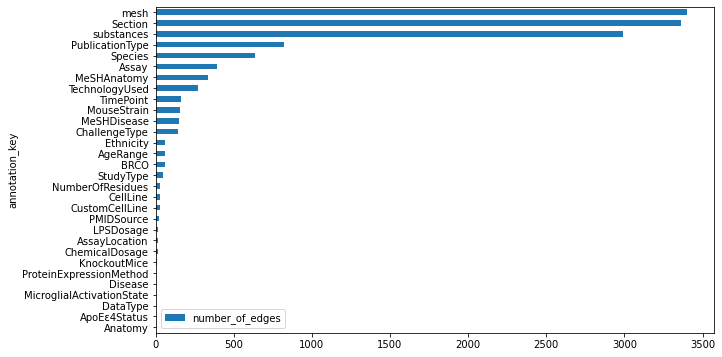

In [12]:
r = requests.get(f"{basic_url}bel/annotation_keys")
_ = pd.DataFrame(r.json()).set_index('annotation_key').iloc[::-1].plot.barh(figsize=(10,6))

#### Terms

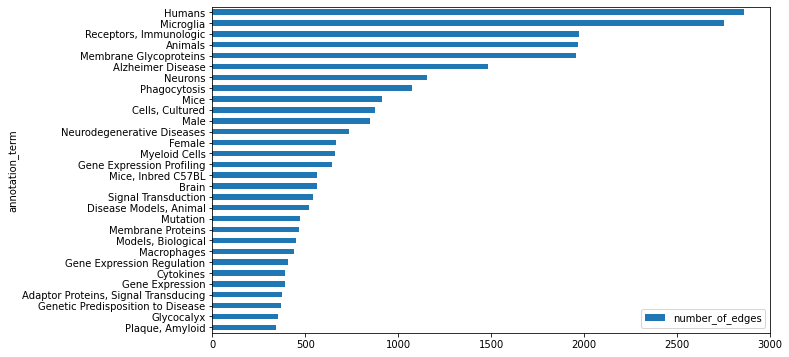

In [13]:
r = requests.get(f"{basic_url}bel/annotation_terms", params={'annotation_key': "mesh"})
_ = pd.DataFrame(r.json()).set_index('annotation_term').iloc[:30].iloc[::-1].plot.barh(figsize=(10,6))

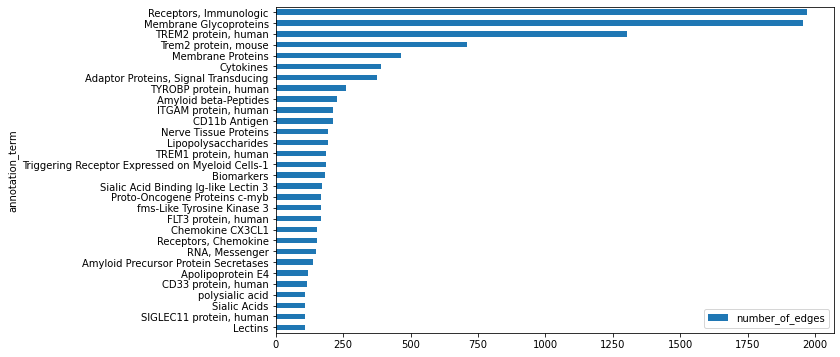

In [14]:
r = requests.get(f"{basic_url}bel/annotation_terms", params={'annotation_key': "substances"})
df = pd.DataFrame(r.json()).iloc[:30]
_ = df.iloc[::-1].set_index('annotation_term').plot.barh(figsize=(10,6))


In [15]:
example_substance = df.annotation_term[10]
example_substance

'CD11b Antigen'

### Edges by annotation

In [16]:
params = {} 
r = requests.get(f"{basic_url}bel/edge_by_annotation", params=params)
pd.DataFrame(r.json()['results'])

,author_in_author_list,citation_full_journal_name,citation_last_author,citation_pub_date,citation_pub_year,citation_type,doi,evidence,object_bel,object_gene_symbol_involved_in,...,relation,relation_rid,subject_bel,subject_gene_symbol_involved_in,subject_name,subject_namespace,subject_node_class,subject_other_involved_in,subject_rid,title
0,"[Zhong L, Chen XF, Wang T, Wang Z, Liao C, Wan...",The Journal of experimental medicine,Bu G,2017-08-14,2017,PubMed,10.1084/jem.20160844,Soluble TREM2 induces inflammatory responses a...,"bp(GOBP:""inflammatory response"")",[],...,increases,#554:0,"p(HGNC:""TREM2"",loc(MESHA:""Extracellular Space""))",[TREM2],TREM2,HGNC,protein,[],#186:0,Soluble TREM2 induces inflammatory responses a...
1,"[Sims R, van der Lee SJ, Naj AC, Bellenguez C,...",Nature genetics,Schellenberg GD,2017-10-25,2017,PubMed,10.1038/ng.3916,PLCG2 variants also cause antibody deficiency ...,"path(HP:""Decreased antibody level in blood"")",[],...,increases,#554:1,"p(HGNC:""PLCG2"",var(""?""))",[PLCG2],PLCG2,HGNC,protein,[],#191:1,"Rare coding variants in PLCG2, ABI3, and TREM2..."
2,"[Jay TR, von Saucken VE, Landreth GE]",Molecular neurodegeneration,Landreth GE,2018-06-12,2018,PubMed,10.1186/s13024-017-0197-5,"In vitro, application of classically pro-infla...","p(HGNC:""TREM2"")",[TREM2],...,increases,#554:2,"p(HGNC:""IL4"")",[IL4],IL4,HGNC,protein,[],#187:3,TREM2 in Neurodegenerative Diseases.
3,"[Xiang X, Werner G, Bohrmann B, Liesz A, Mazah...",EMBO molecular medicine,Haass C,2017-09-25,2017,PubMed,10.15252/emmm.201606370,It is well known that upon stimulation of TREM...,"p(HGNC:""SYK"",pmod(Ph))",[SYK],...,increases,#554:3,"act(p(SCOMP:""FcR Gamma Chain Complex""))",[FcR Gamma Chain Complex],NaN,NaN,activity,[],#237:0,TREM2 deficiency reduces the efficacy of immun...
4,"[Sieber MW, Jaenisch N, Brehm M, Guenther M, L...",PloS one,Frahm C,2013-08-20,2013,PubMed,10.1371/journal.pone.0052982,"At 7 d after MCAO, transcription of TNFα, IL-1...","r(MGI:""Il1b"")",[Il1b],...,increases,#554:4,"p(MGI:""Trem2"")",[Trem2],Trem2,MGI,protein,[],#192:3,Attenuated inflammatory response in triggering...
5,"[Linnartz B, Wang Y, Neumann H]",International journal of Alzheimer's disease,Neumann H,2011-07-14,2011,PubMed,10.4061/2010/587463,"On the one hand, they are neurotoxic by produc...","p(HGNC:""IL1B"")",[IL1B],...,increases,#554:5,"bp(GOBP:""cytokine production involved in infla...",[],cytokine production involved in inflammatory r...,GOBP,biological_process,[cytokine production involved in inflammatory ...,#75:0,Microglial immunoreceptor tyrosine-based activ...
6,"[Linnartz B, Wang Y, Neumann H]",International journal of Alzheimer's disease,Neumann H,2011-07-14,2011,PubMed,10.4061/2010/587463,Different receptors expressed on microglia suc...,"bp(GOBP:""beta-amyloid clearance"")",[],...,increases,#554:6,"p(HGNC:""CD14"",loc(MESHA:""Microglia""))",[CD14],CD14,HGNC,protein,[],#189:7,Microglial immunoreceptor tyrosine-based activ...
7,"[Linnartz B, Wang Y, Neumann H]",International journal of Alzheimer's disease,Neumann H,2011-07-14,2011,PubMed,10.4061/2010/587463,"Accordingly, microglial cells express the acti...","p(HGNC:""FCGR3A"")",[FCGR3A],...,increases,#554:7,"a(MESHA:""Microglia"")",[],Microglia,MESHA,abundance,[Microglia],#122:0,Microglial immunoreceptor tyrosine-based activ...
8,"[Linnartz B, Wang Y, Neumann H]",International journal of Alzheimer's disease,Neumann H,2011-07-14,2011,PubMed,10.4061/2010/587463,"Furthermore, TREM2 and SIRPβ1 are plaque-assoc...","bp(GOBP:""phagocytosis"")",[],...,increases,#554:8,"p(HGNC:""TREM2"",loc(MESHA:""Microglia""))",[TREM2],TREM2,HGNC,protein,[],#192:0,Microglial immunoreceptor tyrosine-based activ...
9,"[Linnartz B, Wang Y, Neumann H]",International journal of Alzheimer's disease,Neumann H,2011-07-14,2011,PubMed,10.4061/2010/587463,"Most CD33-related Siglecs, such as the human S...","p(HGNC:""SIGLEC11"")",[SIGLEC11],...,increases,#554:9,"a(MESHA:""Monocytes"")",[],Monocytes,MESHA,abundance,

### Adjacent nodes by identifier

Let's remember what we are searching for

In [17]:
start_node = requests.get(f"{basic_url}bel/by_rid", params={'rid': example_node_rid}).json()
print('Adjacent nodes of ', start_node['bel'])

Adjacent nodes of  p(HGNC:"TREM2",loc(MESHA:"Extracellular Space"))


#### Directions

##### in

In [18]:
params = {'rid': example_node_rid, 'direction': "in"}
r = requests.get(f"{basic_url}bel/adjacent_nodes_by_rid", params=params)
pd.DataFrame(r.json()).head(3)

,bel,direction,edge_class,edge_rid,involved_genes,involved_other,name,namespace,node_class,node_rid
0,"bp(GOBP:""inflammatory response"")",in,increases,#554:0,[],[inflammatory response],inflammatory response,GOBP,biological_process,#74:0
1,"a(MESHA:""Microglia"")",in,increases,#555:0,[],[Microglia],Microglia,MESHA,abundance,#122:0
2,"a(MESHA:""Microglia"")",in,increases,#556:0,[],[Microglia],Microglia,MESHA,abundance,#122:0


##### out

In [19]:
params = {'rid': example_node_rid, 'direction': "out"}
r = requests.get(f"{basic_url}bel/adjacent_nodes_by_rid", params=params)
pd.DataFrame(r.json()).head(3)

,bel,direction,edge_class,edge_rid,involved_genes,involved_other,name,namespace,node_class,node_rid
0,"bp(GOBP:""membrane protein ectodomain proteolys...",out,increases,#559:10,[],[membrane protein ectodomain proteolysis],membrane protein ectodomain proteolysis,GOBP,biological_process,#87:2
1,"act(p(HGNC:""TREM2""),ma(GOBP:""membrane protein ...",out,increases,#563:38,[TREM2],[membrane protein ectodomain proteolysis],membrane protein ectodomain proteolysis,GOBP,activity,#247:0
2,"p(HGNC:""TREM2"",loc(MESHA:""Cell Membrane""))",out,increases,#568:14,[TREM2],[],TREM2,HGNC,protein,#198:11


##### both

In [20]:
params = {'rid': example_node_rid, 'direction': "both"}
r = requests.get(f"{basic_url}bel/adjacent_nodes_by_rid", params=params)
df = pd.DataFrame(r.json())
df.head(1)

,bel,direction,edge_class,edge_rid,involved_genes,involved_other,name,namespace,node_class,node_rid
0,"bp(GOBP:""inflammatory response"")",in,increases,#554:0,[],[inflammatory response],inflammatory response,GOBP,biological_process,#74:0


to see also outs we output also the last three

In [21]:
df.tail(1)

,bel,direction,edge_class,edge_rid,involved_genes,involved_other,name,namespace,node_class,node_rid
30,"a(CHEBI:""florbetaben ((18)F)"")",out,positive_correlation,#682:48,[],[florbetaben ((18)F)],florbetaben ((18)F),CHEBI,abundance,#136:9


**both** is default and not needed

In [22]:
params = {'rid': example_node_rid}
r = requests.get(f"{basic_url}bel/adjacent_nodes_by_rid", params=params)
df = pd.DataFrame(r.json())
df.head(1)

,bel,direction,edge_class,edge_rid,involved_genes,involved_other,name,namespace,node_class,node_rid
0,"bp(GOBP:""inflammatory response"")",in,increases,#554:0,[],[inflammatory response],inflammatory response,GOBP,biological_process,#74:0


In [23]:
df.tail(1)

,bel,direction,edge_class,edge_rid,involved_genes,involved_other,name,namespace,node_class,node_rid
30,"a(CHEBI:""florbetaben ((18)F)"")",out,positive_correlation,#682:48,[],[florbetaben ((18)F)],florbetaben ((18)F),CHEBI,abundance,#136:9


#### Relation type

Following relation types are available

In [24]:
print(get_enums('adjacent_nodes_by_rid', 'relation'))

['bel_relation', 'association', 'causal', 'correlative', 'decreases', 'directly_decreases', 'directly_increases', 'equivalent_to', 'genomic', 'has_component', 'has_components', 'has_member', 'has_members', 'increases', 'is_a', 'negative_correlation', 'no_correlation', 'orthologous', 'other', 'positive_correlation', 'rate_limiting_step_of', 'regulates', 'sub_process_of', 'transcribed_to', 'translated_to']


In [25]:
params = {'rid': example_node_rid, 'relation': 'increases'}
r = requests.get(f"{basic_url}bel/adjacent_nodes_by_rid", params=params)
df = pd.DataFrame(r.json())
df.head(1)

,bel,direction,edge_class,edge_rid,involved_genes,involved_other,name,namespace,node_class,node_rid
0,"bp(GOBP:""inflammatory response"")",in,increases,#554:0,[],[inflammatory response],inflammatory response,GOBP,biological_process,#74:0


### Edges by annoation

In [26]:
params = {'annotation_key': "substances", 'annotation_term': example_substance, 'page': 2, 'page_size':3}
r = get_api_result('bel/edge_by_annotation', **params)
r.print_page_info()
print("edges with mesh substance:", example_substance)
r.as_df()

number_of_results: 211
page: 2
pages: 71
page_size: 3
edges with mesh substance: CD11b Antigen


,annotation_key,author_in_author_list,citation_full_journal_name,citation_last_author,citation_pub_date,citation_pub_year,citation_type,doi,evidence,object_bel,...,relation,relation_rid,subject_bel,subject_gene_symbol_involved_in,subject_name,subject_namespace,subject_node_class,subject_other_involved_in,subject_rid,title
0,"[CD11b Antigen, ITGAM protein, human]","[Galatro TF, Holtman IR, Lerario AM, Vainchtei...",Nature neuroscience,Eggen BJL,2017-09-05,2017,PubMed,10.1038/nn.4597,A network involved in cell motility and inflam...,"r(HGNC:""ITGB2"")",...,increases,#554:52,"a(MESHA:""Microglia"")",[],Microglia,MESHA,abundance,[Microglia],#122:0,Transcriptomic analysis of purified human cort...
1,"[CD11b Antigen, ITGAM protein, human]","[Galatro TF, Holtman IR, Lerario AM, Vainchtei...",Nature neuroscience,Eggen BJL,2017-09-05,2017,PubMed,10.1038/nn.4597,"ERAP2, along with the closely related ERAP1, a...","r(HGNC:""ERAP2"")",...,increases,#554:53,"a(MESHA:""Microglia"")",[],Microglia,MESHA,abundance,[Microglia],#122:0,Transcriptomic analysis of purified human cort...
2,"[CD11b Antigen, ITGAM protein, human]","[Galatro TF, Holtman IR, Lerario AM, Vainchtei...",Nature neuroscience,Eggen BJL,2017-09-05,2017,PubMed,10.1038/nn.4597,The target list contains many established micr...,"r(HGNC:""AIF1"")",...,increases,#554:54,"a(MESHA:""Microglia"")",[],Microglia,MESHA,abundance,[Microglia],#122:0,Transcriptomic analysis of purified human cort...


### edges

This is a complex method with many parameters.

In [27]:
get_params('edges')

[{'description': 'You can also use several rids seperated by comma', 'in': 'query', 'name': 'subject_rid', 'schema': {'type': 'string'}}, {'in': 'query', 'name': 'subject_node_class', 'schema': {'enum': ['gene', 'rna', 'protein', 'abundance', 'activity', 'biological_process', 'complex', 'micro_rna', 'pathology', 'population'], 'example': 'protein', 'type': 'string'}}, {'in': 'query', 'name': 'subject_namespace', 'schema': {'example': 'HGNC', 'type': 'string'}}, {'description': 'use % as wildcard', 'in': 'query', 'name': 'subject_name', 'schema': {'example': 'IL4', 'type': 'string'}}, {'description': 'use % as wildcard', 'in': 'query', 'name': 'subject_bel', 'schema': {'type': 'string'}}, {'in': 'query', 'name': 'subject_gene_symbol_involved_in', 'schema': {'type': 'string'}}, {'in': 'query', 'name': 'subject_other_involved_in', 'schema': {'type': 'string'}}, {'description': 'You can also use several rids seperated by comma', 'in': 'query', 'name': 'edge_rid', 'schema': {'type': 'string

,description,required,dtype,example,options
name,,,,,
subject_rid,You can also use several rids seperated by comma,False,string,None,
subject_node_class,,False,string,protein,"[gene, rna, protein, abundance, activity, biol..."
subject_namespace,,False,string,HGNC,
subject_name,use % as wildcard,False,string,IL4,
subject_bel,use % as wildcard,False,string,None,
subject_gene_symbol_involved_in,,False,string,None,
subject_other_involved_in,,False,string,None,
edge_rid,You can also use several rids seperated by comma,False,string,None,
relation,,False,string,increases,"[bel_relation, association, causal, correlativ..."


In [28]:
params = {'relation': "increases", 'page': 2, 'page_size':3}
r = get_api_result('bel/edges', **params)
r.print_page_info()
r.as_df()

number_of_results: 1817
page: 2
pages: 606
page_size: 3


,author_in_author_list,citation_full_journal_name,citation_last_author,citation_pub_date,citation_pub_year,citation_type,doi,evidence,object_bel,object_gene_symbol_involved_in,...,relation,relation_rid,subject_bel,subject_gene_symbol_involved_in,subject_node_class,subject_other_involved_in,subject_rid,title,subject_name,subject_namespace
0,"[Xiang X, Werner G, Bohrmann B, Liesz A, Mazah...",EMBO molecular medicine,Haass C,2017-09-25,2017,PubMed,10.15252/emmm.201606370,It is well known that upon stimulation of TREM...,"p(HGNC:""SYK"",pmod(Ph))",[SYK],...,increases,#554:3,"act(p(SCOMP:""FcR Gamma Chain Complex""))",[FcR Gamma Chain Complex],activity,[],#237:0,TREM2 deficiency reduces the efficacy of immun...,NaN,NaN
1,"[Sieber MW, Jaenisch N, Brehm M, Guenther M, L...",PloS one,Frahm C,2013-08-20,2013,PubMed,10.1371/journal.pone.0052982,"At 7 d after MCAO, transcription of TNFα, IL-1...","r(MGI:""Il1b"")",[Il1b],...,increases,#554:4,"p(MGI:""Trem2"")",[Trem2],protein,[],#192:3,Attenuated inflammatory response in triggering...,Trem2,MGI
2,"[Linnartz B, Wang Y, Neumann H]",International journal of Alzheimer's disease,Neumann H,2011-07-14,2011,PubMed,10.4061/2010/587463,"On the one hand, they are neurotoxic by produc...","p(HGNC:""IL1B"")",[IL1B],...,increases,#554:5,"bp(GOBP:""cytokine production involved in infla...",[],biological_process,[cytokine production involved in inflammatory ...,#75:0,Microglial immunoreceptor tyrosine-based activ...,cytokine production involved in inflammatory r...,GOBP


#### List all node types

In [29]:
r = requests.get(f"{basic_url}bel/node_types").json()
pd.DataFrame(r).T.fillna('')

,abstract,children,in_relations,out_relations,parents_path
abundance,False,[],"[has__abundance, has_located_abundance]",[has_located_abundance],"[abundance, bio_object, bel, V]"
activity,False,[],,,"[activity, bio_act, bel, V]"
bel,True,"[{'abstract': False, 'name': 'bio_act'}, {'abs...","[translocates, correlative, sub_process_of, ha...","[translocates, correlative, sub_process_of, ha...","[bel, V]"
bio_act,False,"[{'abstract': False, 'name': 'degradation'}, {...",,,"[bio_act, bel, V]"
bio_concept,True,"[{'abstract': False, 'name': 'pathology'}, {'a...",,,"[bio_concept, bel, V]"
bio_list,True,"[{'abstract': False, 'name': 'list'}, {'abstra...",,,"[bio_list, bel, V]"
bio_object,True,"[{'abstract': False, 'name': 'micro_rna'}, {'a...",,,"[bio_object, bel, V]"
biological_process,False,[],,,"[biological_process, bio_concept, bel, V]"
cell_secretion,False,[],,,"[cell_secretion, bio_act, bel, V]"
cell_surface_expression,False,[],,,"[cell_surface_expression, bio_act, bel, V]"


#### List all relation types

In [30]:
r = requests.get(f"{basic_url}bel/relation_types").json()
pd.DataFrame(r).T.fillna('')

,abstract,children,in_out,parents_path
acts_in,False,[],"{'in': 'bel', 'out': 'bel'}","[acts_in, compiler, bel_relation, E]"
analogous_to,False,[],"{'in': 'bel', 'out': 'bel'}","[analogous_to, deprecated, bel_relation, E]"
association,False,[],"{'in': 'bel', 'out': 'bel'}","[association, correlative, bel_relation, E]"
bel_relation,True,"[{'abstract': True, 'name': 'correlative'}, {'...",,"[bel_relation, E]"
biomarker_for,False,[],"{'in': 'bel', 'out': 'bel'}","[biomarker_for, deprecated, bel_relation, E]"
causal,True,"[{'abstract': False, 'name': 'regulates'}, {'a...","{'in': 'bel', 'out': 'bel'}","[causal, bel_relation, E]"
causes_no_change,False,[],"{'in': 'bel', 'out': 'bel'}","[causes_no_change, causal, bel_relation, E]"
compiler,True,"[{'abstract': False, 'name': 'translocates'}, ...",,"[compiler, bel_relation, E]"
correlative,True,"[{'abstract': False, 'name': 'association'}, {...","{'in': 'bel', 'out': 'bel'}","[correlative, bel_relation, E]"
decreases,False,[],"{'in': 'bel', 'out': 'bel'}","[decreases, causal, bel_relation, E]"


### Get information on children and parent types of a specific node or edge type

In [31]:
requests.get(f"{basic_url}bel/class_info_by_name", params={'name': 'causal'}).json()

{'abstract': True,
 'children': [{'abstract': False, 'name': 'regulates'},
  {'abstract': False, 'name': 'causes_no_change'},
  {'abstract': False, 'name': 'increases'},
  {'abstract': False, 'name': 'directly_decreases'},
  {'abstract': False, 'name': 'rate_limiting_step_of'},
  {'abstract': False, 'name': 'decreases'},
  {'abstract': False, 'name': 'directly_increases'}],
 'in_out': {'in': 'bel', 'out': 'bel'},
 'parents_path': ['causal', 'bel_relation', 'E']}

In [32]:
requests.get(f"{basic_url}bel/class_info_by_name", params={'name': 'protein'}).json()

{'abstract': False,
 'children': [],
 'in_relations': ['has_located_protein',
  'has_modified_protein',
  'has_variant_protein',
  'translated_to',
  'has_drug_target_db',
  'has_action',
  'has_ppi',
  'has__protein'],
 'out_relations': ['has_located_protein',
  'has_modified_protein',
  'has_variant_protein',
  'has_action',
  'has_ppi'],
 'parents_path': ['protein', 'genetic_flow', 'bio_object', 'bel', 'V']}

### Nodes

In [33]:
get_params('nodes')

[{'in': 'query', 'name': 'node_class', 'required': True, 'schema': {'enum': ['bel', 'genetic_flow', 'gene', 'rna', 'protein', 'abundance', 'activity', 'biological_process', 'complex', 'micro_rna', 'pathology', 'population'], 'example': 'protein', 'type': 'string'}}, {'in': 'query', 'name': 'namespace', 'schema': {'type': 'string'}}, {'in': 'query', 'name': 'name', 'schema': {'type': 'string'}}, {'description': "'pure' is a tag for no modification (mod), variation (var) or location (loc).", 'in': 'query', 'name': 'pure', 'schema': {'type': 'boolean'}}, {'description': 'Select BEL relation the node is conneceted to.', 'in': 'query', 'name': 'connected_to_bel_relation', 'schema': {'enum': ['acts_in', 'analogous_to', 'association', 'bel_relation', 'biomarker_for', 'causal', 'causes_no_change', 'compiler', 'correlative', 'decreases', 'deprecated', 'directly_decreases', 'directly_increases', 'genomic', 'has_modification', 'has_product', 'has_variant', 'includes', 'increases', 'negative_corre

,required,description,dtype,example,options
name,,,,,
node_class,True,,string,protein,"[bel, genetic_flow, gene, rna, protein, abunda..."
namespace,False,,string,None,
name,False,,string,None,
pure,False,"'pure' is a tag for no modification (mod), var...",boolean,None,
connected_to_bel_relation,False,Select BEL relation the node is conneceted to.,string,None,"[acts_in, analogous_to, association, bel_relat..."
connected_to_bel_relation_direction,False,Only valid if connected_to_bel_relation is set.,string,None,"[in, out, both]"
connected_to_ebel_relation,False,Select e(BE:L) relation the node is conneceted...,string,None,"[activates__iu, activates_st, agonist_of__iu, ..."
connected_to_ebel_relation_direction,False,Only valid if connected_to_ebel_relation is set.,string,None,"[in, out, both]"
page_size,False,Results per page,integer,10,


In [34]:
r = get_api_result(f"bel/nodes", node_class="protein")
r.print_page_info()
r.as_df().fillna('').head(3)

number_of_results: 19562
page: 1
pages: 1957
page_size: 10


,bel,involved_genes,involved_other,name,namespace,rid,pure
0,"p(HGNC:""TREM2"",loc(MESHA:""Extracellular Space""))",[TREM2],[],TREM2,HGNC,#186:0,
1,"p(HGNC:""RELA"")",[RELA],[],RELA,HGNC,#186:1,True
2,"p(HGNC:""TREM2"",var(""p.Leu211Pro""))",[TREM2],[],TREM2,HGNC,#186:2,


In [35]:
r = get_api_result(f"bel/nodes", node_class="complex")
r.print_page_info()
r.as_df().fillna('').head(3)

number_of_results: 283
page: 1
pages: 29
page_size: 10


,bel,involved_genes,involved_other,pure,rid
0,"complex(p(HGNC:""APOE""),p(HGNC:""TREM2""))","[APOE, TREM2]",[],True,#106:0
1,"complex(a(CHEBI:""amyloid-beta""),p(HGNC:""CD14"")...","[CD14, TLR2]",[amyloid-beta],True,#106:1
2,"complex(a(CHEBI:""amyloid-beta""),p(HGNC:""LDLR""))",[LDLR],[amyloid-beta],True,#106:2


### Number of BEL edges

all

In [36]:
requests.get(f"{basic_url}bel/number_of_edges").json()

145010

#### BEL

In [37]:
requests.get(f"{basic_url}bel/number_of_edges", params={'relation':'bel_relation'}).json()

5981

In [38]:
requests.get(f"{basic_url}bel/number_of_edges", params={'relation':'increases'}).json()

1817

#### e(BE:L)

In [39]:
requests.get(f"{basic_url}bel/number_of_edges", params={'relation':'ebel_relation'}).json()

139029

In [40]:
requests.get(f"{basic_url}bel/number_of_edges", params={'relation':'has_ppi'}).json()

65691

### Number of nodes

all

In [41]:
requests.get(f"{basic_url}bel/number_of_nodes").json()

36467

filter for specific node classes

In [42]:
print(get_enums('number_of_nodes', 'node_class'))

['abundance', 'activity', 'bel', 'bio_act', 'bio_concept', 'bio_list', 'bio_object', 'biological_process', 'cell_secretion', 'cell_surface_expression', 'complex', 'composite', 'degradation', 'drug', 'drug_db', 'ebel', 'fragment', 'from_location', 'fusion_gene', 'fusion_protein', 'fusion_rna', 'gene', 'genetic_flow', 'gmod', 'list', 'location', 'micro_rna', 'pathology', 'pmod', 'population', 'products', 'protein', 'reactants', 'reaction', 'rna', 'side_effect', 'snp', 'to_location', 'translocation', 'variant']


#### BEL

In [43]:
requests.get(f"{basic_url}bel/number_of_nodes", params={'node_class': "bel"}).json()

25875

In [44]:
requests.get(f"{basic_url}bel/number_of_nodes", params={'node_class': "protein", 'pure': True}).json()

18221

In [45]:
requests.get(f"{basic_url}bel/number_of_nodes", params={'node_class': "complex"}).json()

283

#### e(BE:L)

In [46]:
requests.get(f"{basic_url}bel/number_of_nodes", params={'node_class': "ebel"}).json()

10592

In [47]:
requests.get(f"{basic_url}bel/number_of_nodes", params={'node_class': "snp"}).json()

3921

In [53]:
requests.get(f"{basic_url}bel/paths", params={'start_node_class':"protein", 'limit':1}).json()

{'edge_paths_by_length': {'1': [['#1805:927']],
  '2': [['#1805:927', '#1348:43']],
  '3': [['#1805:927', '#1348:43', '#1208:43']]},
 'unique_edges': {'#1208:43': {'class': 'has__pmod',
   'object_bel': 'pmod(Ph)',
   'object_rid': '#424:43',
   'subject_bel': 'p(HGNC:"CLU",pmod(Ph))',
   'subject_rid': '#201:790'},
  '#1348:43': {'class': 'has_modified_protein',
   'object_bel': 'p(HGNC:"CLU",pmod(Ph))',
   'object_rid': '#201:790',
   'subject_bel': 'p(HGNC:"CLU")',
   'subject_rid': '#190:15'},
  '#1805:927': {'class': 'has_ppi_ia',
   'object_bel': 'p(HGNC:"CLU")',
   'object_rid': '#190:15',
   'pmid': 31413325,
   'subject_bel': 'p(HGNC:"SPARCL1")',
   'subject_rid': '#187:580'}},
 'unique_nodes': {'#187:580': {'bel': 'p(HGNC:"SPARCL1")',
   'class': 'protein',
   'involved_genes': ['SPARCL1'],
   'involved_other': [],
   'label': 'SPARC like 1',
   'name': 'SPARCL1',
   'namespace': 'HGNC',
   'pure': True,
   'uniprot': 'Q14515'},
  '#190:15': {'bel': 'p(HGNC:"CLU")',
   'class

In [70]:
url = f"{basic_url}bel/paths_as_dot"
params={'start_node_class':"protein", 'limit':1}
r = requests.get(url, params)
print(r.json())

digraph {
	graph [fontname=helvetica]
	node [shape=note]
	node [shape=box]
	node [style=filled]
	node [fillcolor=lightblue1]
	"#190.15" [label=<<FONT POINT-SIZE="10">protein</FONT><BR/><FONT POINT-SIZE="16">CLU</FONT><BR/><FONT POINT-SIZE="6">p(HGNC:"CLU")</FONT>>]
	node [fillcolor=lightblue1]
	"#187.580" [label=<<FONT POINT-SIZE="10">protein</FONT><BR/><FONT POINT-SIZE="16">SPARCL1</FONT><BR/><FONT POINT-SIZE="6">p(HGNC:"SPARCL1")</FONT>>]
	node [fillcolor=lightblue1]
	"#201.790" [label=<<FONT POINT-SIZE="10">protein</FONT><BR/><FONT POINT-SIZE="16">CLU</FONT><BR/><FONT POINT-SIZE="6">p(HGNC:"CLU",pmod(Ph))</FONT>>]
	node [fillcolor=grey]
	"#424.43" [label=<<FONT POINT-SIZE="10">pmod</FONT><BR/><FONT POINT-SIZE="16">; pho; </FONT>>]
	edge [color=grey]
	"#187.580" -> "#190.15" [label=<<FONT POINT-SIZE="8">has_ppi_ia [1]</FONT>>]
	edge [color=grey]
	"#201.790" -> "#424.43" [label=<<FONT POINT-SIZE="8">has__pmod [1]</FONT>>]
	edge [color=grey]
	"#190.15" -> "#201.790" [label=<<FONT POINT

if you want to search and viszualize graphs go [here](Search_and_visualize_biomedical_knowledge_graphs.ipynb)

In [62]:
requests.get(f"{basic_url}bel/paths_by_belish", params={'belish': 'p(HGNC:"%") -increases-> complex(%)'}).json()

{'edge_paths_by_length': {'1': [['#559:40'],
   ['#560:40'],
   ['#555:85'],
   ['#557:6'],
   ['#559:13'],
   ['#560:13'],
   ['#561:13']]},
 'unique_edges': {'#555:85': {'citation': {'author_list': ['Xie P'],
    'doi': '10.1186/1750-2187-8-7',
    'full_journal_name': 'Journal of molecular signaling',
    'last_author': 'Xie P',
    'pub_date': '2013-07-03',
    'pub_year': 2013,
    'ref': '23758787',
    'title': 'TRAF molecules in cell signaling and in human diseases.',
    'type': 'PubMed'},
   'class': 'increases',
   'evidence': 'Additionally, TRAF3-MAVS interaction requires the assistance of another TRAF3-interacting protein, UXT-V1 [133].',
   'object_bel': 'complex(p(HGNC:"MAVS"),p(HGNC:"TRAF3"))',
   'object_rid': '#115:12',
   'pmid': 23758787,
   'subject_bel': 'p(HGNC:"UXT")',
   'subject_rid': '#192:41'},
  '#557:6': {'citation': {'author_list': ['Linnartz B', 'Wang Y', 'Neumann H'],
    'doi': '10.4061/2010/587463',
    'full_journal_name': "International journal of A

In [69]:
params={'belish': 'p(HGNC:"%") -increases-> complex(%)'}
url = f"{basic_url}bel/paths_by_belish_as_dot"
r = requests.get(url, params=params)
print(r.json())

digraph {
	graph [fontname=helvetica]
	node [shape=note]
	node [shape=box]
	node [style=filled]
	node [fillcolor=lightblue1]
	"#192.7" [label=<<FONT POINT-SIZE="10">protein</FONT><BR/><FONT POINT-SIZE="16">CD14</FONT><BR/><FONT POINT-SIZE="6">p(HGNC:"CD14")</FONT>>]
	node [fillcolor=lightblue1]
	"#192.41" [label=<<FONT POINT-SIZE="10">protein</FONT><BR/><FONT POINT-SIZE="16">UXT</FONT><BR/><FONT POINT-SIZE="6">p(HGNC:"UXT")</FONT>>]
	node [fillcolor=khaki1]
	"#113.3" [label=<<FONT POINT-SIZE="10">complex</FONT><BR/><FONT POINT-SIZE="16">TREM2,Monocytes</FONT><BR/><FONT POINT-SIZE="6">complex(a(MESHA:"Monocytes"),p(HGNC:"TREM2"))</FONT>>]
	node [fillcolor=khaki1]
	"#119.0" [label=<<FONT POINT-SIZE="10">complex</FONT><BR/><FONT POINT-SIZE="16">TLR4,lipopolysaccharide</FONT><BR/><FONT POINT-SIZE="6">complex(a(CHEBI:"lipopolysaccharide"),p(HGNC:"TLR4"))</FONT>>]
	node [fillcolor=lightblue1]
	"#195.11" [label=<<FONT POINT-SIZE="10">protein</FONT><BR/><FONT POINT-SIZE="16">LDLR</FONT><BR/><F

### PMIDs

In [94]:
pmids = requests.get(f"{basic_url}bel/pmids").json()
pmids[0]

{'citation': {'author_list': ['Xie P'],
  'doi': '10.1186/1750-2187-8-7',
  'full_journal_name': 'Journal of molecular signaling',
  'last_author': 'Xie P',
  'pub_date': '2013-07-03',
  'pub_year': 2013,
  'ref': '23758787',
  'title': 'TRAF molecules in cell signaling and in human diseases.',
  'type': 'PubMed'},
 'number_of_edges': 644,
 'pmid': 23758787}

In [96]:
df = pd.DataFrame(pmids).set_index('pmid').head(30)
pd.concat([df, df.citation.apply(pd.Series)], axis=1).drop(columns=['citation'])

,number_of_edges,author_list,doi,full_journal_name,last_author,pub_date,pub_year,ref,title,type
pmid,,,,,,,,,,
23758787,644,[Xie P],10.1186/1750-2187-8-7,Journal of molecular signaling,Xie P,2013-07-03,2013,23758787,TRAF molecules in cell signaling and in human ...,PubMed
22615186,254,"[Linnartz B, Neumann H]",10.1002/glia.22359,Glia,Neumann H,2013-09-04,2013,22615186,Microglial activatory (immunoreceptor tyrosine...,PubMed
26207229,237,"[Wang WY, Tan MS, Yu JT, Tan L]",10.3978/j.issn.2305-5839.2015.03.49,Annals of translational medicine,Tan L,2015-07-24,2015,26207229,Role of pro-inflammatory cytokines released fr...,PubMed
29158945,213,"[Liu T, Zhang L, Joo D, Sun SC]",10.1038/sigtrans.2017.23,Signal transduction and targeted therapy,Sun SC,2021-02-02,2021,29158945,NF-κB signaling in inflammation.,PubMed
28671693,211,"[Galatro TF, Holtman IR, Lerario AM, Vainchtei...",10.1038/nn.4597,Nature neuroscience,Eggen BJL,2017-09-05,2017,28671693,Transcriptomic analysis of purified human cort...,PubMed
26694609,182,[Walter J],10.1074/jbc.R115.704981,The Journal of biological chemistry,Walter J,2016-08-01,2016,26694609,The Triggering Receptor Expressed on Myeloid C...,PubMed
28483841,176,"[Mazaheri F, Snaidero N, Kleinberger G, Madore...",10.15252/embr.201743922,EMBO reports,Haass C,2018-03-19,2018,28483841,TREM2 deficiency impairs chemotaxis and microg...,PubMed
28591653,167,"[Haenseler W, Sansom SN, Buchrieser J, Newey S...",10.1016/j.stemcr.2017.05.017,Stem cell reports,Cowley SA,2018-01-29,2018,28591653,A Highly Efficient Human Pluripotent Stem Cell...,PubMed
27429982,154,"[Chen P, Zhao W, Guo Y, Xu J, Yin M]",10.1155/2016/8090918,BioMed research international,Yin M,2017-02-22,2017,27429982,CX3CL1/CX3CR1 in Alzheimer's Disease: A Target...,PubMed


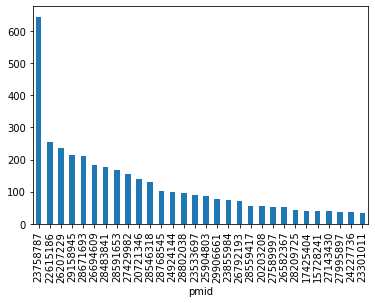

In [105]:
_ = df.number_of_edges.plot.bar()

### Publication year statistics

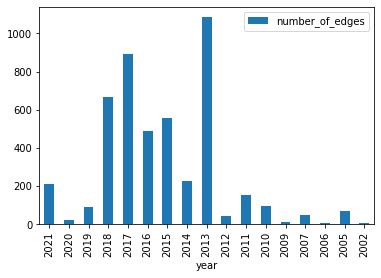

In [107]:
r = requests.get(f"{basic_url}bel/publication_year_statistics").json()
_ = pd.DataFrame(r).set_index('year').plot.bar()

### Get *pure* rid

In [110]:
params = {
    'node_class': "protein", 
    'namespace': "HGNC", 
    'name': "TREM2"
}
requests.get(f"{basic_url}bel/pure_rid", params).json()

'#195:0'

## e(BE:L)

### Relation types

In [120]:
r = requests.get(f"{basic_url}ebel/relation_types").json()
r[list(r.keys())[0]]

{'abstract': False,
 'children': [],
 'in_out': {'in': 'bel', 'out': 'bel'},
 'parents_path': ['activates__iu', 'iuphar_interaction', 'ebel_relation', 'E']}

### Get class info by name

node class

In [123]:
params = {'name': "drug"}
requests.get(f"{basic_url}bel/class_info_by_name", params).json()

{'abstract': True,
 'children': [{'abstract': False, 'name': 'drug_db'}],
 'parents_path': ['drug', 'ebel', 'V']}

edge class

In [112]:
params = {'name': "increases_pho_kg"}
requests.get(f"{basic_url}bel/class_info_by_name", params).json()

{'abstract': False,
 'children': [],
 'parents_path': ['increases_pho_kg',
  'has_ppi_kg',
  'pathway_interaction',
  'ebel_relation',
  'E']}

### Paths by BELish

In [156]:
params={'belish': '[drug] -has_drug_target-> [protein]', 'limit':1}
requests.get(f"{basic_url}bel/paths_by_belish", params).json()

{'edge_paths_by_length': {'1': [['#1572:13']]},
 'unique_edges': {'#1572:13': {'class': 'has_drug_target_db',
   'object_bel': 'p(HGNC:"ADA")',
   'object_rid': '#186:169',
   'subject_rid': '#1549:11'}},
 'unique_nodes': {'#1549:11': {'cas_number': '53910-25-1',
   'class': 'drug_db',
   'description': 'A potent inhibitor of adenosine deaminase. The drug is effective in the treatment of many lymphoproliferative malignancies, particularly hairy-cell leukemia. It is also synergistic with some other antineoplastic agents and has immunosuppressive activity.',
   'drugbank_id': 'DB00552',
   'indication': 'For the treatment of hairy cell leukaemia refractory to alpha interferon.',
   'label': 'Pentostatin',
   'mechanism_of_action': 'Pentostatin is a potent transition state inhibitor of adenosine deaminase (ADA), the greatest activity of which is found in cells of the lymphoid system. T-cells have higher ADA activity than B-cells, and T-cell malignancies have higher activity than B-cell ma

In [171]:
url = f"{basic_url}chebi/ebel/nodes"
params = {'name':'ATP'}
requests.get(url, params=params).json()

{'number_of_results': 73,
 'page': 1,
 'page_size': 10,
 'pages': 8,
 'results': [{'bel': 'a(CHEBI:"ATP")',
   'chebi': 15422,
   'name': 'ATP',
   'namespace': 'CHEBI',
   'rid': '#122:6'}]}

In [191]:
method = "clinvar/ebel/relation"
get_doc_for_api_method(method)

Description
 Search clinvar by e(BE:L) relation


,data type,description,example
parameter name,,,
namespace,string,None,HGNC
name,string,Gene symbol,PSEN1
phenotype,string,None,"Alzheimer disease, type 3"
clinical_significance,string,None,Pathogenic
relation_type,string,None,has_snp_clinvar
keyword,string,None,Alzheimer
rs_number,string,None,rs63750526
page_size,integer,Results per page,10
page,integer,Page number (starting with 1),1


In [192]:
params = {'name':'PSEN1'}
requests.get(basic_url+method, params=params).json()

{'number_of_results': 353,
 'page': 1,
 'page_size': 10,
 'pages': 36,
 'results': [{'clinical_significance': 'Pathogenic',
   'name': 'PSEN1',
   'namespace': 'HGNC',
   'phenotype': 'Alzheimer disease, type 3',
   'relation_type': 'has_mapped_snp_cv',
   'rs_number': 'rs63750306'},
  {'clinical_significance': 'Likely pathogenic',
   'name': 'PSEN1',
   'namespace': 'HGNC',
   'phenotype': 'Alzheimer disease, type 3',
   'relation_type': 'has_mapped_snp_cv',
   'rs_number': 'rs63751399'},
  {'clinical_significance': 'Pathogenic',
   'name': 'PSEN1',
   'namespace': 'HGNC',
   'phenotype': 'Alzheimer disease, type 3',
   'relation_type': 'has_mapped_snp_cv',
   'rs_number': 'rs63750900'},
  {'clinical_significance': 'Conflicting interpretations of pathogenicity',
   'name': 'PSEN1',
   'namespace': 'HGNC',
   'phenotype': 'Alzheimer disease, type 3',
   'relation_type': 'has_mapped_snp_cv',
   'rs_number': 'rs201776669'},
  {'clinical_significance': 'Benign/Likely benign',
   'name': '

In [196]:
method = "disgenet/ebel"
get_doc_for_api_method(method)

Description
 Get SNP-gene relation from e(BE:L) knowledge graph


,data type,description,example
parameter name,,,
relation,string,None,has_dgn_snp
disease_name,string,None,Alzheimer's Disease
rs_number,string,None,rs10408847
pmid,integer,None,29777097
source,string,None,GWASCAT
name,string,Gene symbol,MARK4
namespace,string,Gene symbol namespace,HGNC
page_size,integer,Results per page,10
page,integer,Page number (starting with 1),1


In [200]:
url = f"{basic_url}disgenet/ebel"
params = {'source':'GWASCAT'}
requests.get(basic_url+method, params).json()

{'number_of_results': 2290,
 'page': 1,
 'page_size': 10,
 'pages': 229,
 'results': [{'disease_name': "Alzheimer's Disease",
   'gene_rid': '#157:188',
   'gene_symbol': 'ZNF761',
   'pmids': [26830138],
   'relation': 'has_downstream_snp_dgn',
   'rid': '#3036:50',
   'score': 0.7,
   'snp_rid': '#1602:35',
   'snp_rs_number': 'rs2927694',
   'source': 'GWASCAT'},
  {'disease_name': "Alzheimer's Disease",
   'gene_rid': '#167:56',
   'gene_symbol': 'MTHFD1L',
   'pmids': [20885792],
   'relation': 'has_upstream_snp_dgn',
   'rid': '#3059:11',
   'score': 0.82,
   'snp_rid': '#1604:0',
   'snp_rs_number': 'rs11754661',
   'source': 'GWASCAT'},
  {'disease_name': "Alzheimer's Disease",
   'gene_rid': '#156:62',
   'gene_symbol': 'SCIMP',
   'pmids': [30617256],
   'relation': 'has_downstream_snp_dgn',
   'rid': '#3044:7',
   'score': 0.7,
   'snp_rid': '#1605:27',
   'snp_rs_number': 'rs113260531',
   'source': 'GWASCAT'},
  {'disease_name': 'Parkinson Disease',
   'gene_rid': '#163:20

In [201]:
method = "drugbank/ebel/relation"
get_doc_for_api_method(method)

Description
 Drug/target relation in e(BE:L) knowledge base


,data type,description,example
parameter name,,,
drug_rid,string,e(BE:L) rid,None
drug_name,string,None,Flortaucipir F-18
drugbank_id,string,e(BE:L) rid,DB14914
edge_rid,string,None,None
action,string,None,binder
known_action,string,None,yes
target_rid,string,None,None
target_name,string,e(BE:L) rid,MAPT
target_namespace,string,None,HGNC


In [203]:
url = f"{basic_url}disgenet/ebel"
params = {'target_name':'MAPT'}
requests.get(basic_url+method, params).json()

{'number_of_results': 5,
 'page': 1,
 'page_size': 10,
 'pages': 1,
 'results': [{'action': 'binder',
   'drug_name': 'Flortaucipir F-18',
   'drug_rid': '#1547:104',
   'drugbank_id': 'DB14914',
   'edge_rid': '#1562:157',
   'known_action': 'yes',
   'target_name': 'MAPT',
   'target_namespace': 'HGNC',
   'target_rid': '#190:5',
   'target_uniprot_accession': 'P10636'},
  {'drug_name': 'Lansoprazole',
   'drug_rid': '#1546:104',
   'drugbank_id': 'DB00448',
   'edge_rid': '#1574:156',
   'known_action': 'unknown',
   'target_name': 'MAPT',
   'target_namespace': 'HGNC',
   'target_rid': '#190:5',
   'target_uniprot_accession': 'P10636'},
  {'drug_name': 'Astemizole',
   'drug_rid': '#1552:91',
   'drugbank_id': 'DB00637',
   'edge_rid': '#1575:156',
   'known_action': 'unknown',
   'target_name': 'MAPT',
   'target_namespace': 'HGNC',
   'target_rid': '#190:5',
   'target_uniprot_accession': 'P10636'},
  {'drug_name': 'Paclitaxel',
   'drug_rid': '#1554:1',
   'drugbank_id': 'DB0122

In [213]:
method = "ebel/biogrid/modification/by_symbol_taxid"
get_doc_for_api_method(method)


/api/v1/ebel/biogrid/modification/by_symbol_taxid
Description
 Get e(BE:L) has_ppi_bg by subject (and object) gene symbol and taxonomy ID


,data type,description,example
parameter name,,,
symbol,string,Gene symbol,MAPT
taxonomy_id,integer,NCBI taxonomy ID,9606
modification,string,Posttranslational modification of interactor B...,None


In [ ]:
url = f"{basic_url}disgenet/ebel"
params = {'target_name':'MAPT'}
requests.get(basic_url+method, params).json()